<a href="https://www.kaggle.com/code/pablorocamora/unet-brain-mri-segmentation-99-accuracy?scriptVersionId=110730463" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# BRAIN MRI SEGMENTATION | UNET Tensorflow implementation
## By [Pablo Rocamora García](http://pablorocamora.es)

# Import libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm


# Loading and reading images and masks

In [2]:
%%time
root = '../input/lgg-mri-segmentation/kaggle_3m'

# os.listdir(root)
#Reading 

def get_images_path():
    images = []
    labels = []
    for d in tqdm(os.listdir(root)):
        path = os.path.join(root, d)
        if os.path.isdir(path):
            iters = int(len(os.listdir(path))/2)
            for i in range(iters): 
                file = os.path.join(path, d) + '_' +str(i+1) + '.tif'
                mask = os.path.join(path, d) + '_' +str(i+1) + '_mask.tif'
                images.append(file)
                labels.append(mask)
    return images, labels

def read_images(paths, tipefile):
    images = []
    
    if tipefile == 'images':
        for f in tqdm(paths):
            img = read_image(f)
            images.append(img)    
    else:
        
        for f in tqdm(paths):
            img = read_mask(f)

            images.append(img)
    
    imgs1 = np.array(images)
    
    return imgs1
    
#  
def read_image(path):
    
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x,(128,128))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x,(128,128))
    x = x/255.0
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x




            
imgs, labels = get_images_path()
images = read_images(imgs, 'images')
masks = read_images(labels, 'masks')

100%|██████████| 3929/3929 [00:19<00:00, 196.75it/s]


CPU times: user 4.45 s, sys: 2.53 s, total: 6.98 s
Wall time: 55.5 s


In [3]:
print('Imagenes', images.shape)
print('Etiquetas', masks.shape)

Imagenes (3929, 128, 128, 3)
Etiquetas (3929, 128, 128, 1)


# Visualization

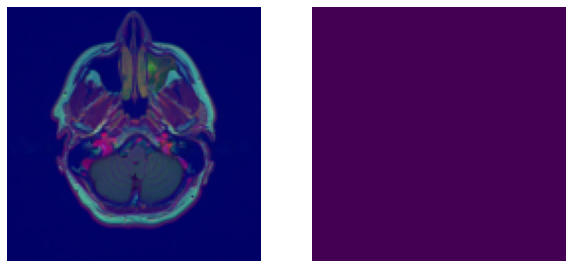

In [4]:
import random

n = random.randint(0, len(images))
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(images[n])

plt.axis('off')
plt.subplot(1, 2, 2)

plt.imshow(masks[n])

plt.axis('off')
plt.show()

# Preparing images for traing

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, 
                                                    masks, 
                                                    test_size=.25, 
                                                    random_state = 288)

In [6]:
print('X_train: ',  X_train.shape)
print('X_test: ',  X_test.shape)
print('y_train: ',  y_train.shape)
print('y_test: ',  y_test.shape)

X_train:  (2946, 128, 128, 3)
X_test:  (983, 128, 128, 3)
y_train:  (2946, 128, 128, 1)
y_test:  (983, 128, 128, 1)


# UNET model 

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


def double_conv_block(x, n_filters):
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    return x

def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)
    return f, p


def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

def build_unet_model():
    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model



unet_model = build_unet_model()

2022-11-11 19:50:42.151807: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 19:50:42.311283: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 19:50:42.312239: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-11 19:50:42.314119: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# Training

In [8]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5',
                                       save_weights_only=True,
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only=True)]


unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="sparse_categorical_crossentropy",
                  metrics="accuracy")



BATCH_SIZE = 128
NUM_EPOCHS = 20



model_history = unet_model.fit(X_train,
                               y_train,
                               verbose=1,
                               epochs = NUM_EPOCHS,
                               validation_data=(X_test, y_test), 
                               callbacks=my_callbacks)

2022-11-11 19:50:47.052187: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-11-11 19:50:49.490495: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


93/93 [==============================] - 39s 290ms/step - loss: 1.7010 - accuracy: 0.9787 - val_loss: 0.2647 - val_accuracy: 0.9895
Epoch 2/20
93/93 [==============================] - 23s 248ms/step - loss: 0.0327 - accuracy: 0.9906 - val_loss: 0.0666 - val_accuracy: 0.9901
Epoch 3/20
93/93 [==============================] - 23s 249ms/step - loss: 0.0299 - accuracy: 0.9917 - val_loss: 0.1323 - val_accuracy: 0.9903
Epoch 4/20
93/93 [==============================] - 23s 249ms/step - loss: 0.0343 - accuracy: 0.9910 - val_loss: 0.0281 - val_accuracy: 0.9919
Epoch 5/20
93/93 [==============================] - 23s 248ms/step - loss: 0.0272 - accuracy: 0.9917 - val_loss: 0.0274 - val_accuracy: 0.9919
Epoch 6/20
93/93 [==============================] - 23s 248ms/step - loss: 0.0259 - accuracy: 0.9918 - val_loss: 0.0260 - val_accuracy: 0.9922
Epoch 7/20
93/93 [==============================] - 23s 248ms/step - loss: 0.0236 - accuracy: 0.9926 - val_loss: 0.0242 - val_accuracy: 0.9929
Epoch 8/20

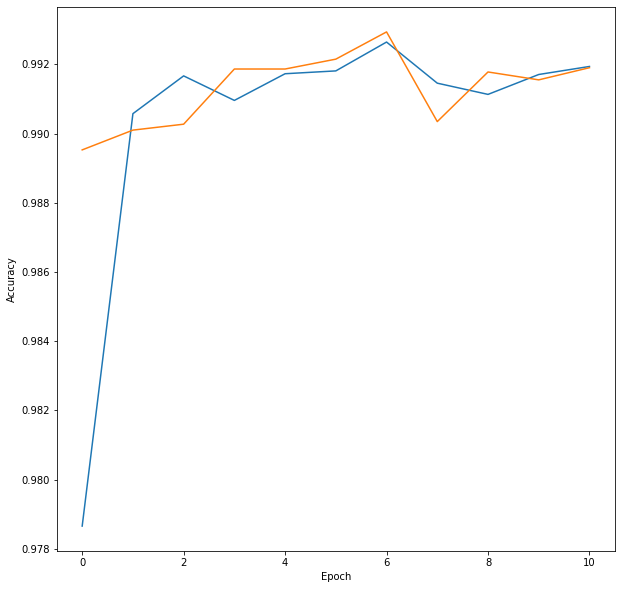

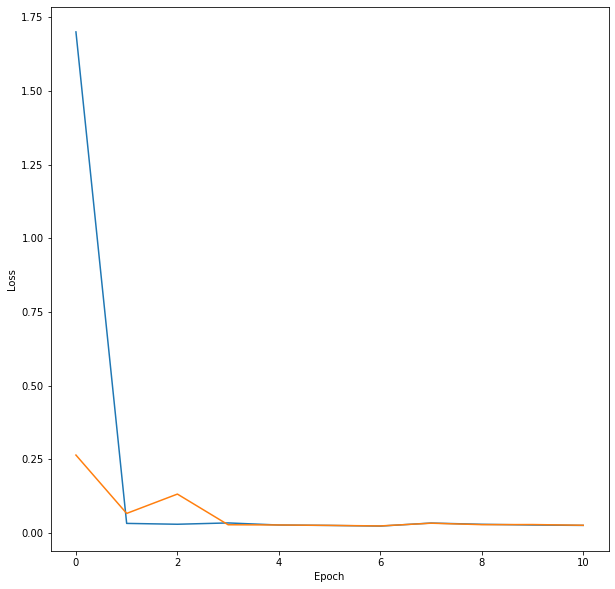

In [9]:
plt.figure(figsize=(10,10))
plt.plot(np.arange(0,len(model_history.history['loss'])), model_history.history['accuracy'])
plt.plot(np.arange(0,len(model_history.history['loss'])), model_history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.figure(figsize=(10,10))
plt.plot(np.arange(0,len(model_history.history['loss'])), model_history.history['loss'])
plt.plot(np.arange(0,len(model_history.history['loss'])), model_history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


# Evaluating and predicting

In [10]:
y_pred = unet_model.predict(X_test)
y_pred = np.where(y_pred >= .4, y_pred, 0)
y_pred = np.where(y_pred < .4, y_pred, 1)


y_pred = np.array([cv2.cvtColor(x, cv2.COLOR_BGR2GRAY) for x in y_pred])
y_pred = np.expand_dims(y_pred, axis=-1)

In [11]:
def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    dice = tf.reduce_mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice



m = tf.keras.metrics.MeanIoU(num_classes=2)
m.update_state(y_test, y_pred)

Dice = float(dice_coefficient(y_test, y_pred, smooth=15))
    
print('Intersection over Union (IoU)', m.result().numpy())
print('Dice score', Dice)

Intersection over Union (IoU) 0.49476433
Dice score 0.045876845717430115


# Final result

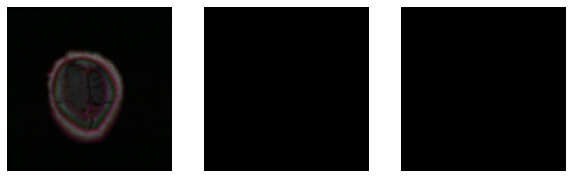

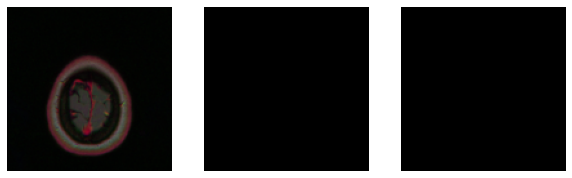

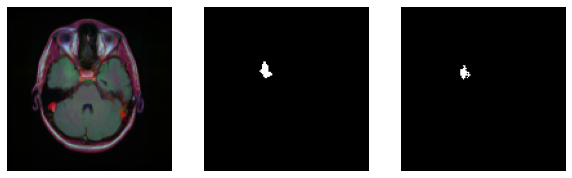

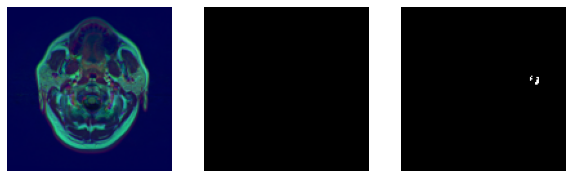

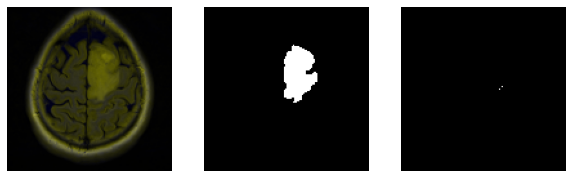

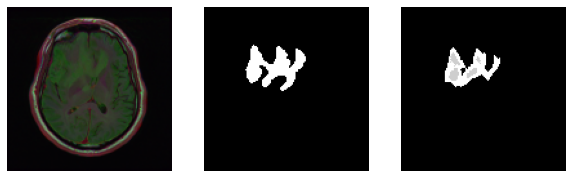

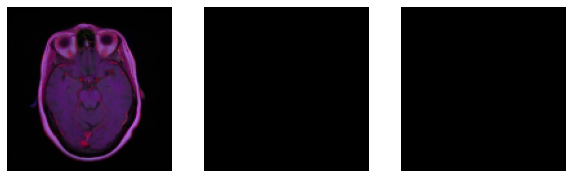

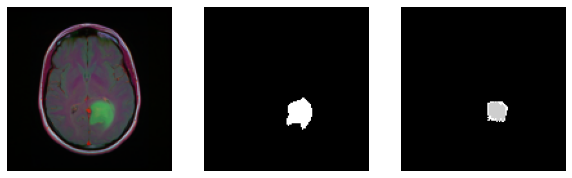

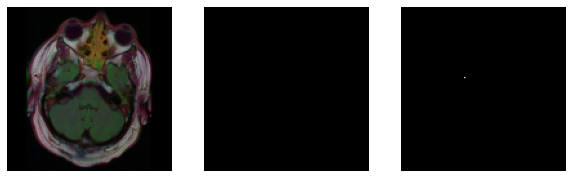

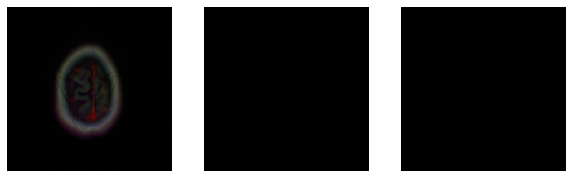

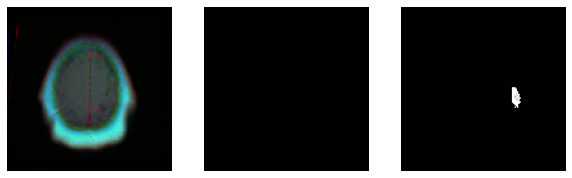

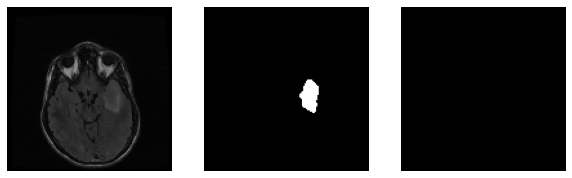

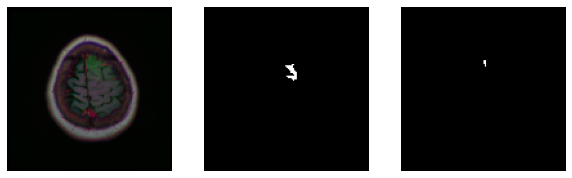

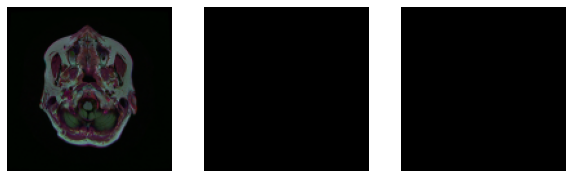

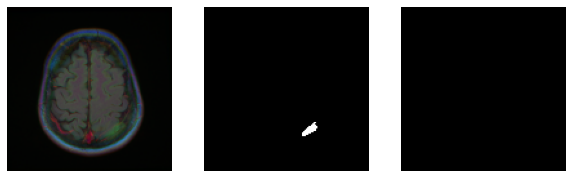

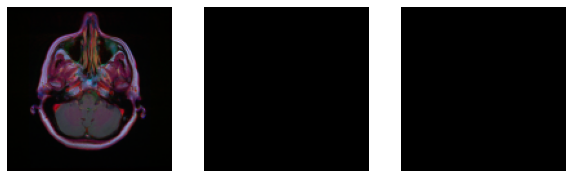

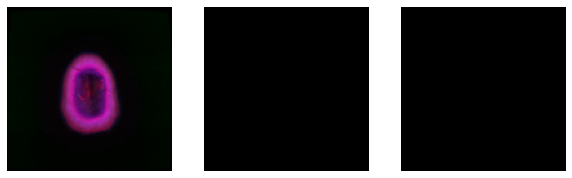

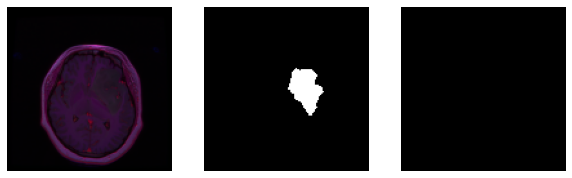

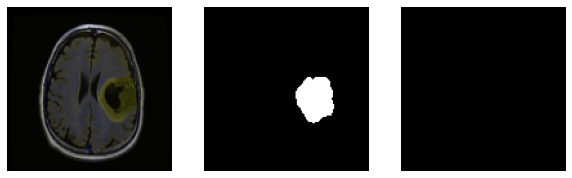

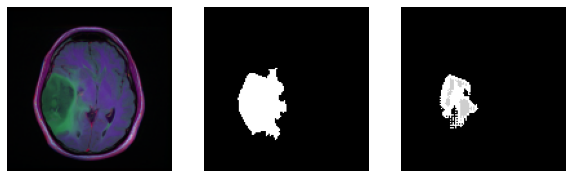

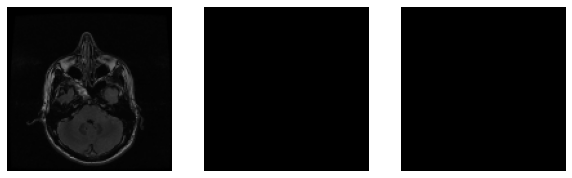

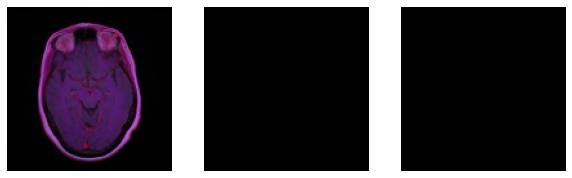

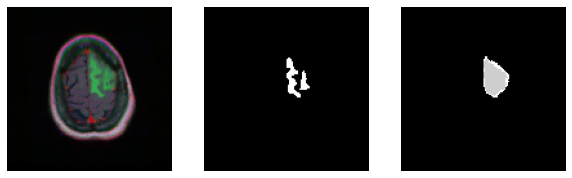

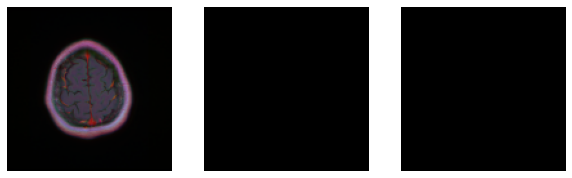

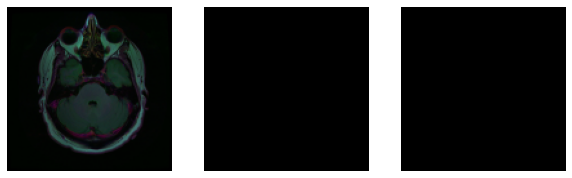

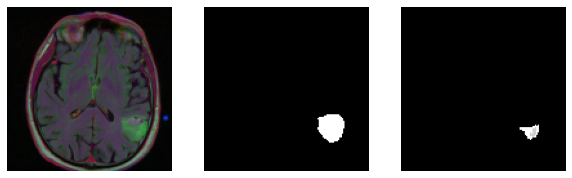

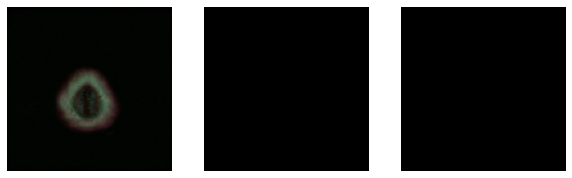

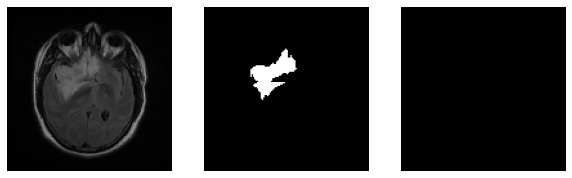

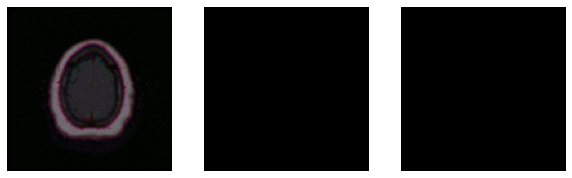

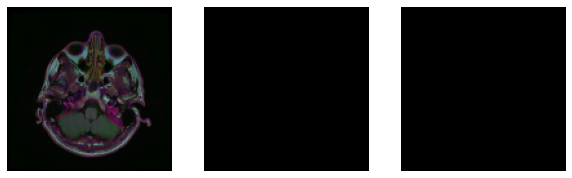

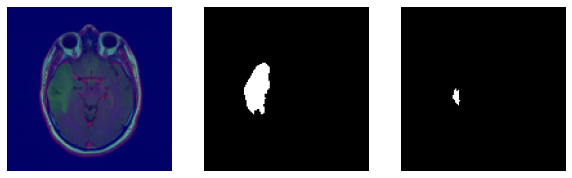

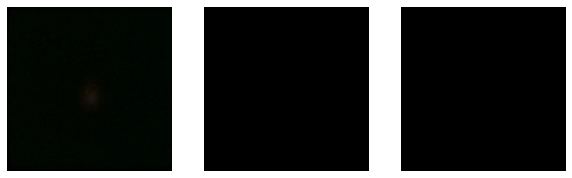

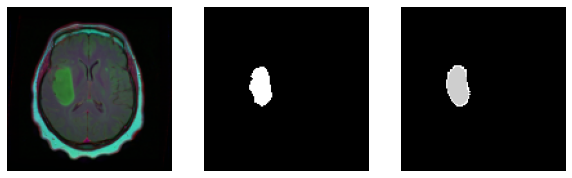

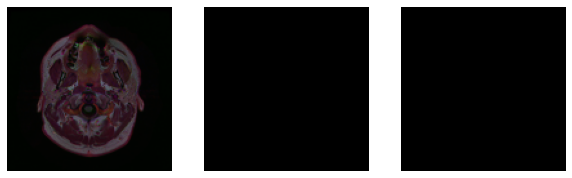

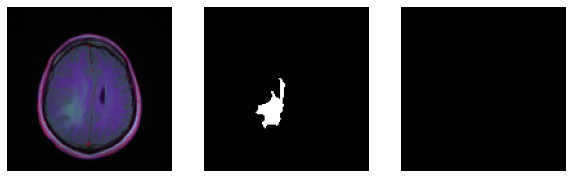

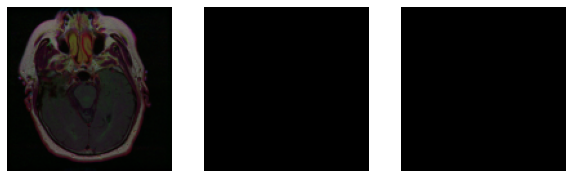

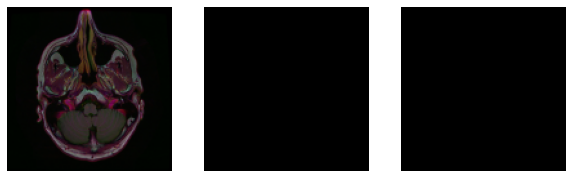

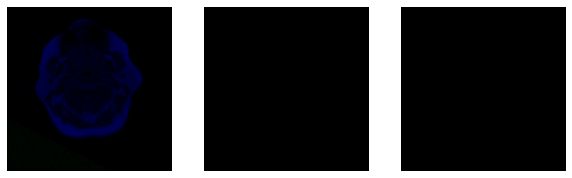

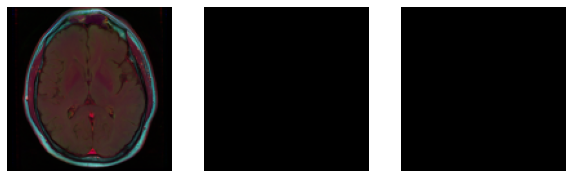

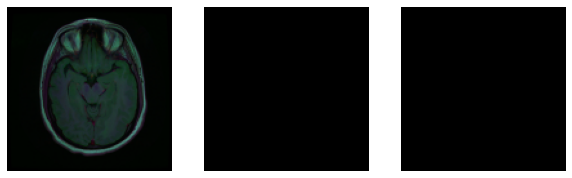

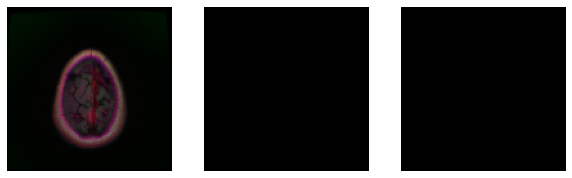

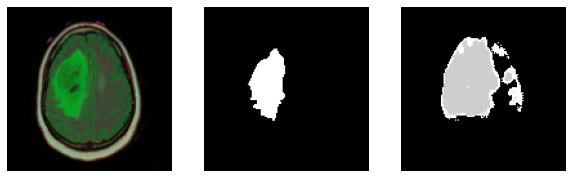

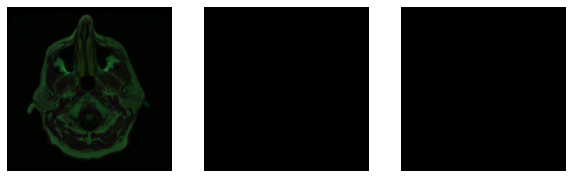

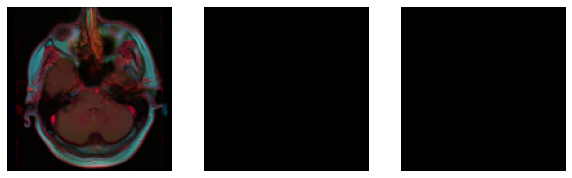

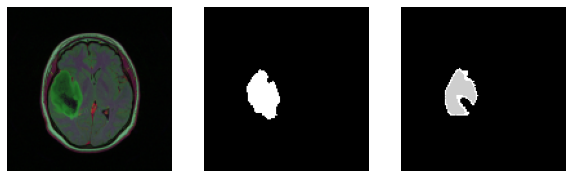

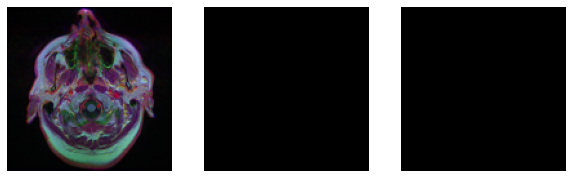

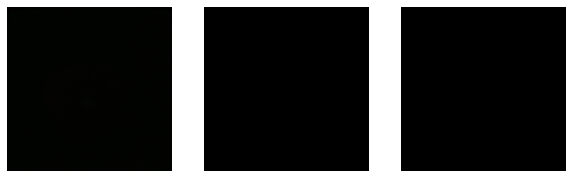

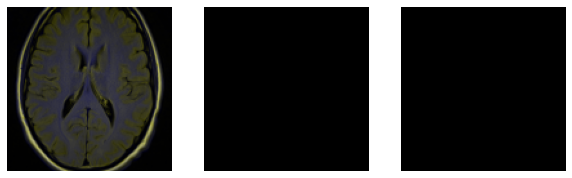

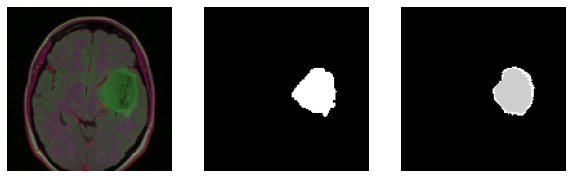

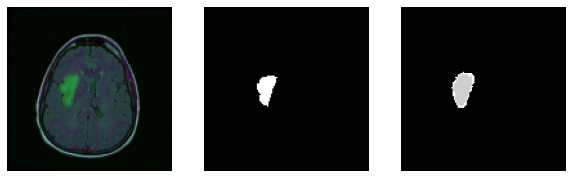

In [12]:
for idx in range(0, 50):
    plt.figure(figsize=(10,10))
    plt.subplot(1, 3, 1)
    plt.imshow(X_test[idx])
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(y_test[idx],cmap='gray')

    plt.axis('off')
    plt.subplot(1, 3, 3)

    plt.imshow(y_pred[idx],cmap='gray')

    plt.axis('off')
    plt.show()